### Evaluation Notebook
Here we will evaluate the fine-tuned Geneformer model performance compared to simpler baselines, namely Logistic Regression and a Neural Network

In [1]:
from datasets import load_from_disk
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, f1_score, \
                            precision_recall_curve, average_precision_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

/Users/erykkropiwnicki/.pyenv/versions/retrobio/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load and transform input data

In [2]:
# Load arrow dataset
dataset = load_from_disk("PD_data/PD.dataset")

# Convert to pyarrow Table
table = dataset.data.table

# Convert pyarrow Table to pandas DataFrame
df = table.to_pandas()

In [3]:
# Carried over from notebook 2 for test and training set stratification consistency
train_ids = ["3482","3346","3873","5610","3322","3345","4956",
             "4560","4568","2142"]
eval_ids = ["6173","3887"]
test_ids = ["3298","1963"]

In [4]:
df_train = df[df["donor_id"].isin(train_ids + eval_ids)]
df_test = df[df["donor_id"].isin(test_ids)]

#### The maximum length for each input array is 2048, however, not all arrays will be of this length, so we must pad them with zeros in those cases

In [5]:
# Function to pad arrays
def pad_array(array, max_length):
    return np.pad(array, (0, max_length - len(array)), 'constant')

X_train_padded = np.array([pad_array(x, 2048) for x in np.array(df_train['input_ids'])])
y_train = [1 if x == "Parkinson disease" else 0 for x in df_train['disease_status']]

X_test_padded =  np.array([pad_array(x, 2048) for x in np.array(df_test['input_ids'])])
y_test = [1 if x == "Parkinson disease" else 0 for x in df_test['disease_status']]

### Create master dict to keep track of model metrics 

In [6]:
all_metrics = {}

### Train Logistic Regression

In [7]:
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_padded, y_train)


y_pred = lr_model.predict(X_test_padded)
y_prob = lr_model.predict_proba(X_test_padded)
accuracy = accuracy_score(y_test, y_pred)
auroc = roc_auc_score(y_test,y_pred)
f1 = f1_score(y_test,y_pred)
print(f'Accuracy: {accuracy}')
print(f'AUROC: {auroc}')
print(f'F1 score: {f1}')

Accuracy: 0.4565529622980251
AUROC: 0.47882554437106617
F1 score: 0.457299946214068


In [17]:
y_scores = y_prob[:, 1]
# PRC
precision, recall, _ = precision_recall_curve(y_test,y_scores)
average_precision = average_precision_score(y_test, y_scores)
# AUROC
fpr, tpr, _ = roc_curve(y_test,y_scores)

In [18]:
all_metrics["Logistic Regression"] = {
    "tpr":tpr,
    "fpr":fpr,
    "auroc":auroc,
    "precision":precision,
    "recall":recall,
    "average_precision":average_precision
}

### Train Neural Network

In [10]:
# Convert input_ids to PyTorch tensors
X_train_tensor = torch.tensor(X_train_padded, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_padded, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [11]:
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 2)  # Output layer for 2 classes

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [13]:
# Initialize the model, loss function and optimizer
torch.manual_seed(42)
model = SimpleNN(X_train_padded.shape[1])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}')

Epoch 10/50, Loss: 0.7462853789329529
Epoch 20/50, Loss: 0.6990205645561218
Epoch 30/50, Loss: 0.6660789847373962
Epoch 40/50, Loss: 0.6807752251625061
Epoch 50/50, Loss: 0.6633569598197937


In [14]:
# Evaluation
model.eval()
true_labels = []
preds = []
probs = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        probabilities = torch.softmax(outputs, dim=1)[:, 1]

        true_labels.extend(labels.cpu().numpy())
        preds.extend(predicted.cpu().numpy())
        probs.extend(probabilities.cpu().numpy())

true_labels = np.array(true_labels)
preds = np.array(preds)
probs = np.array(probs)

# Calculate AUROC
auroc = roc_auc_score(true_labels, probs)
print(f'AUROC: {auroc}')

# Calculate F1 score
f1 = f1_score(true_labels, preds)
print(f'F1 Score: {f1}')

# Accuracy
accuracy = (true_labels == preds).mean()
print(f'Accuracy: {accuracy * 100}%')

AUROC: 0.49992355908882435
F1 Score: 0.0
Accuracy: 39.138240574506284%


In [19]:
# PRC
precision, recall, _ = precision_recall_curve(true_labels,probs)
average_precision = average_precision_score(true_labels, probs)
# AUROC
fpr, tpr, _ = roc_curve(true_labels,probs)

In [20]:
all_metrics["Neural Network"] = {
    "tpr":tpr,
    "fpr":fpr,
    "auroc":auroc,
    "precision":precision,
    "recall":recall,
    "average_precision":average_precision
}

### Load in Geneformer metrics

In [21]:
# Read in predictions
file_path = "pd_classifier/pd_classifier_pred_dict.pkl"

with open(file_path, 'rb') as file:
    pred_dict = pickle.load(file)

# Read in test metrics
file_path = "pd_classifier/pd_classifier_test_metrics_dict.pkl"

with open(file_path, 'rb') as file:
    metrics_dict = pickle.load(file)

In [22]:
metrics_dict.keys()

dict_keys(['conf_matrix', 'macro_f1', 'acc', 'all_roc_metrics'])

In [23]:
# Calculate AUROC
print(f'AUROC: {metrics_dict['all_roc_metrics']['all_roc_auc']}')

# Calculate F1 score
print(f'F1 Score: {metrics_dict['macro_f1']}')

# Accuracy
print(f'Accuracy: {metrics_dict['acc'] * 100}%')

AUROC: 0.8507539807042362
F1 Score: 0.6380420756800892
Accuracy: 71.54997007779772%


In [24]:
pred_dict.keys()

dict_keys(['pred_ids', 'label_ids', 'predictions'])

In [44]:
y_true, y_pred, y_scores = pred_dict['label_ids'], \
                           pred_dict['pred_ids'], \
                          [row[1] for row in pred_dict['predictions']]

In [45]:
# AUROC
tpr = metrics_dict['all_roc_metrics']['mean_tpr']
fpr = metrics_dict['all_roc_metrics']['mean_fpr']
auroc = metrics_dict['all_roc_metrics']['all_roc_auc']
# PRC
precision, recall, _ = precision_recall_curve(y_true,y_scores)
average_precision = average_precision_score(y_true, y_scores)

In [46]:
all_metrics["Geneformer"] = {
    "tpr":tpr,
    "fpr":fpr,
    "auroc":auroc,
    "precision":precision,
    "recall":recall,
    "average_precision":average_precision
}

### AUROC

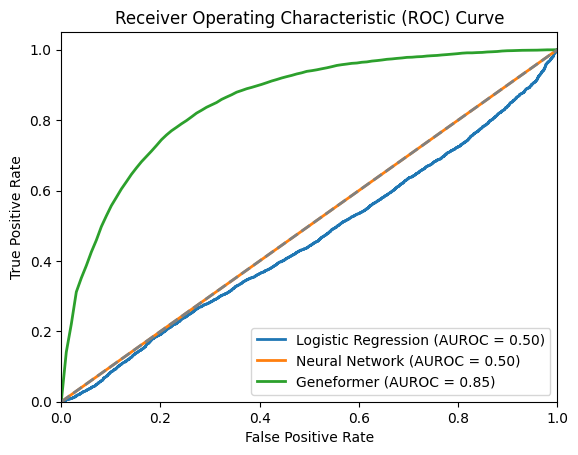

In [50]:
plt.figure()
for model, data in all_metrics.items():
    plt.plot(data['fpr'], data['tpr'], lw=2, label=f'{model} (AUROC = {data["auroc"]:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig("auroc.png", dpi = 300)


### Precision-Recall Curve

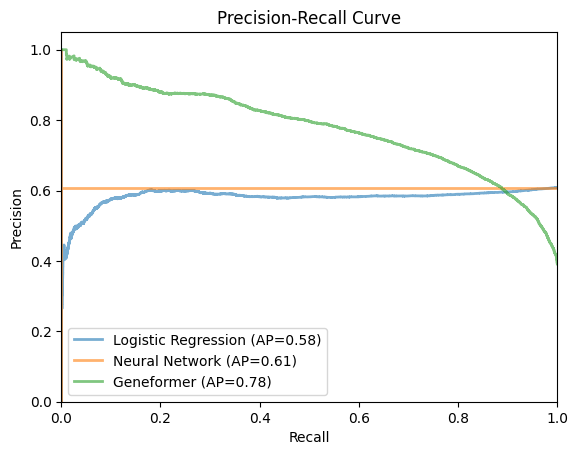

In [51]:
plt.figure()
for model, data in all_metrics.items():
    plt.step(data['recall'], data['precision'], where='post', lw=2, alpha=0.6, label=f'{model} (AP={data["average_precision"]:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend(loc="lower left")
plt.savefig("prc.png", dpi=300)